In [4]:
!pip install seaborn
!pip install tensorflow

    100% |████████████████████████████████| 92.5MB 4.8kB/s eta 0:00:01  6% |██▏                             | 6.3MB 14.2MB/s eta 0:00:07    52% |████████████████▋               | 48.2MB 26.3MB/s eta 0:00:02    59% |███████████████████             | 54.8MB 23.3MB/s eta 0:00:02    74% |████████████████████████        | 69.1MB 27.7MB/s eta 0:00:01    79% |█████████████████████████▌      | 73.8MB 29.9MB/s eta 0:00:01    81% |██████████████████████████      | 75.1MB 26.9MB/s eta 0:00:01    94% |██████████████████████████████▍ | 87.8MB 24.9MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 1.6MB/s eta 0:00:01
    100% |████████████████████████████████| 3.2MB 136kB/s eta 0:00:01
    100% |████████████████████████████████| 368kB 873kB/s eta 0:00:01
    100% |████████████████████████████████| 10.8MB 40kB/s  eta 0:00:01   31% |██████████▏                     | 3.4MB 28.9MB/s eta 0:00:01    79% |█████████████████████████▌      | 8.6MB 22.7MB/s eta 0:00:01
    100% |████████████████

In [5]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [6]:
print(tf.__version__)



1.13.1


In [7]:
"""
This notebook uses the classic Auto MPG Dataset and builds a model to predict 
the fuel efficiency of late-1970s and early 1980s automobiles. To do this, 
we'll provide the model with a description of many automobiles from that time period. 
This description includes attributes like: cylinders, displacement, horsepower, and weight.
"""

dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/home/paws/.keras/datasets/auto-mpg.data'

In [8]:
# import dataset using pandas
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
# drop row with bad values
dataset.isna().sum()
dataset = dataset.dropna()



In [10]:
# drop category colums (values "USA, japan, other" and convert to three collums)
# USA, Japan, Other each of which takes a 0/1 value
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

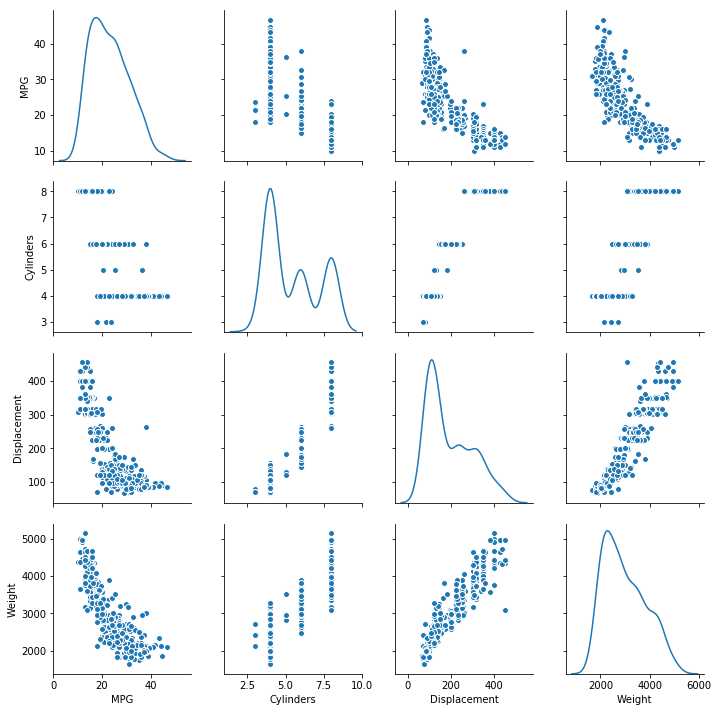

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [14]:
# look at general stats for data
train_stats = train_dataset.describe()
train_stats.pop("MPG") # miles per galon
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [15]:
# separate label and features

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# normalize features
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [16]:

"""
Let's build our model. Here, we'll use a Sequential model with two densely 
connected hidden layers, and an output layer that returns a single, continuous value
"""


def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]), #needs to know number of inputs
    layers.Dense(64, activation=tf.nn.relu), #relu activation y = max(0,x) linear if x>0
    layers.Dense(1) # no activation cause it is a linear function
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error']) # metrics calculated to see how well model is doing
  return model

model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
# take 10 examples from normed train data
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.08835188],
       [ 0.10313454],
       [ 0.77511406],
       [-0.07469881],
       [ 0.05337571],
       [ 0.37775832],
       [ 0.05601408],
       [ 0.23992512],
       [ 0.44722676],
       [ 0.15501332]], dtype=float32)

In [19]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# an ephoch is a full iteration over samples
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [20]:
# visualize model training process
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

# look at loss and validation loss
#Overfitting if: training loss << validation loss

#Underfitting if: training loss >> validation loss

#Just right if training loss ~ validation loss
# loss : difference to value, bias
# validation_loss: variance, variability of model prediction

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.553091,1.037462,2.553091,8.908630,2.361032,8.908629,995
996,2.691000,1.060704,2.691000,8.561385,2.271480,8.561386,996
997,2.480490,1.008589,2.480490,8.915443,2.363787,8.915442,997
998,2.583865,1.036895,2.583864,8.278137,2.224650,8.278136,998
999,2.501532,1.053180,2.501533,8.348103,2.199461,8.348102,999


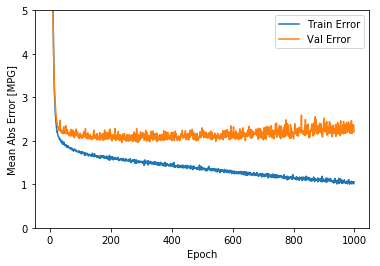

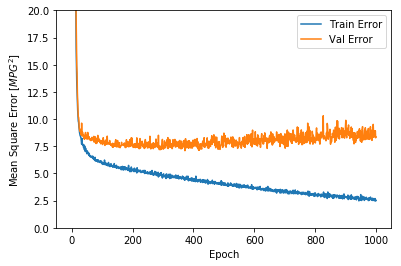

In [22]:
# plot history, see that from epoch 100 there is little variation
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


............................................................

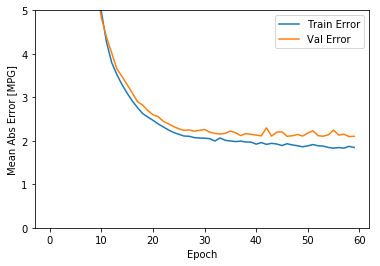

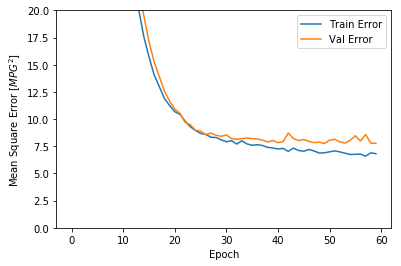

In [23]:
"""
Looks like model does not need to iterate for 1000 epochs, orange going up means 
we are overfitting (high variance= high validation loss)


We'll use an EarlyStopping callback that tests a training condition for every epoch. 
If a set amount of epochs elapses without showing improvement, then automatically stop the training.
"""
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
# it will wait for 10 iterations before calling it quits
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

# look at plot, both are looking down

Testing set Mean Abs Error:  1.89 MPG


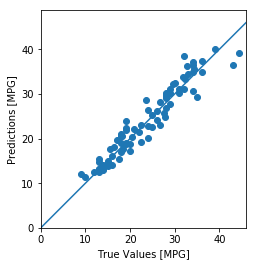

In [24]:
# evaluate model with test data

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

# predict values using data on testing set:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


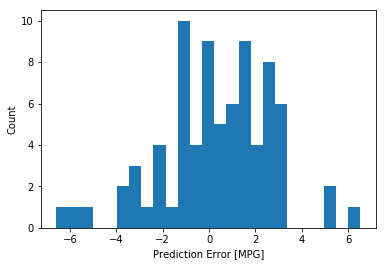

In [25]:
# let's look at error distribution
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# looks "somewhat" gaussian but given that number of samples is very small we cannot expect much else

In [ ]:
# 